# 1. Work with Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import shap
import lime

In [45]:
# load the dataset
diabetes_data = pd.read_csv("./diabetes.csv")

columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = diabetes_data[columns]
features = data.columns.drop('Outcome')

## EDA

### Corelation

In [37]:
correlation_matrix = data.corr()

# absolute correlation values (+ or -)
top_correlations = (correlation_matrix
                    .unstack()
                    .sort_values(ascending=False)
                    .drop_duplicates()
                    .reset_index()
                    .rename(columns={0: 'Correlation'})
                    .query('level_0 != level_1'))  # exclude self-correlations

print("Top Correlations:")
print(top_correlations.head(5))

Top Correlations:
       level_0        level_1  Correlation
1  Pregnancies            Age     0.544341
2      Glucose        Outcome     0.466581
3      Insulin  SkinThickness     0.436783
4          BMI  SkinThickness     0.392573
5      Glucose        Insulin     0.331357


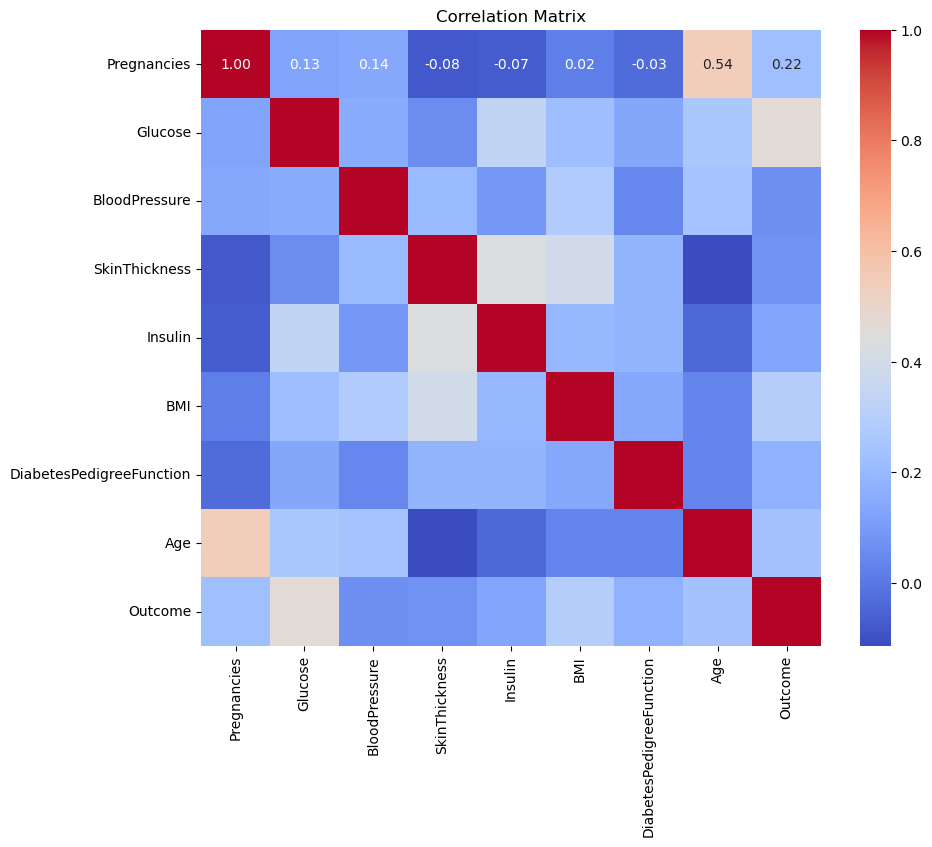

In [34]:
# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

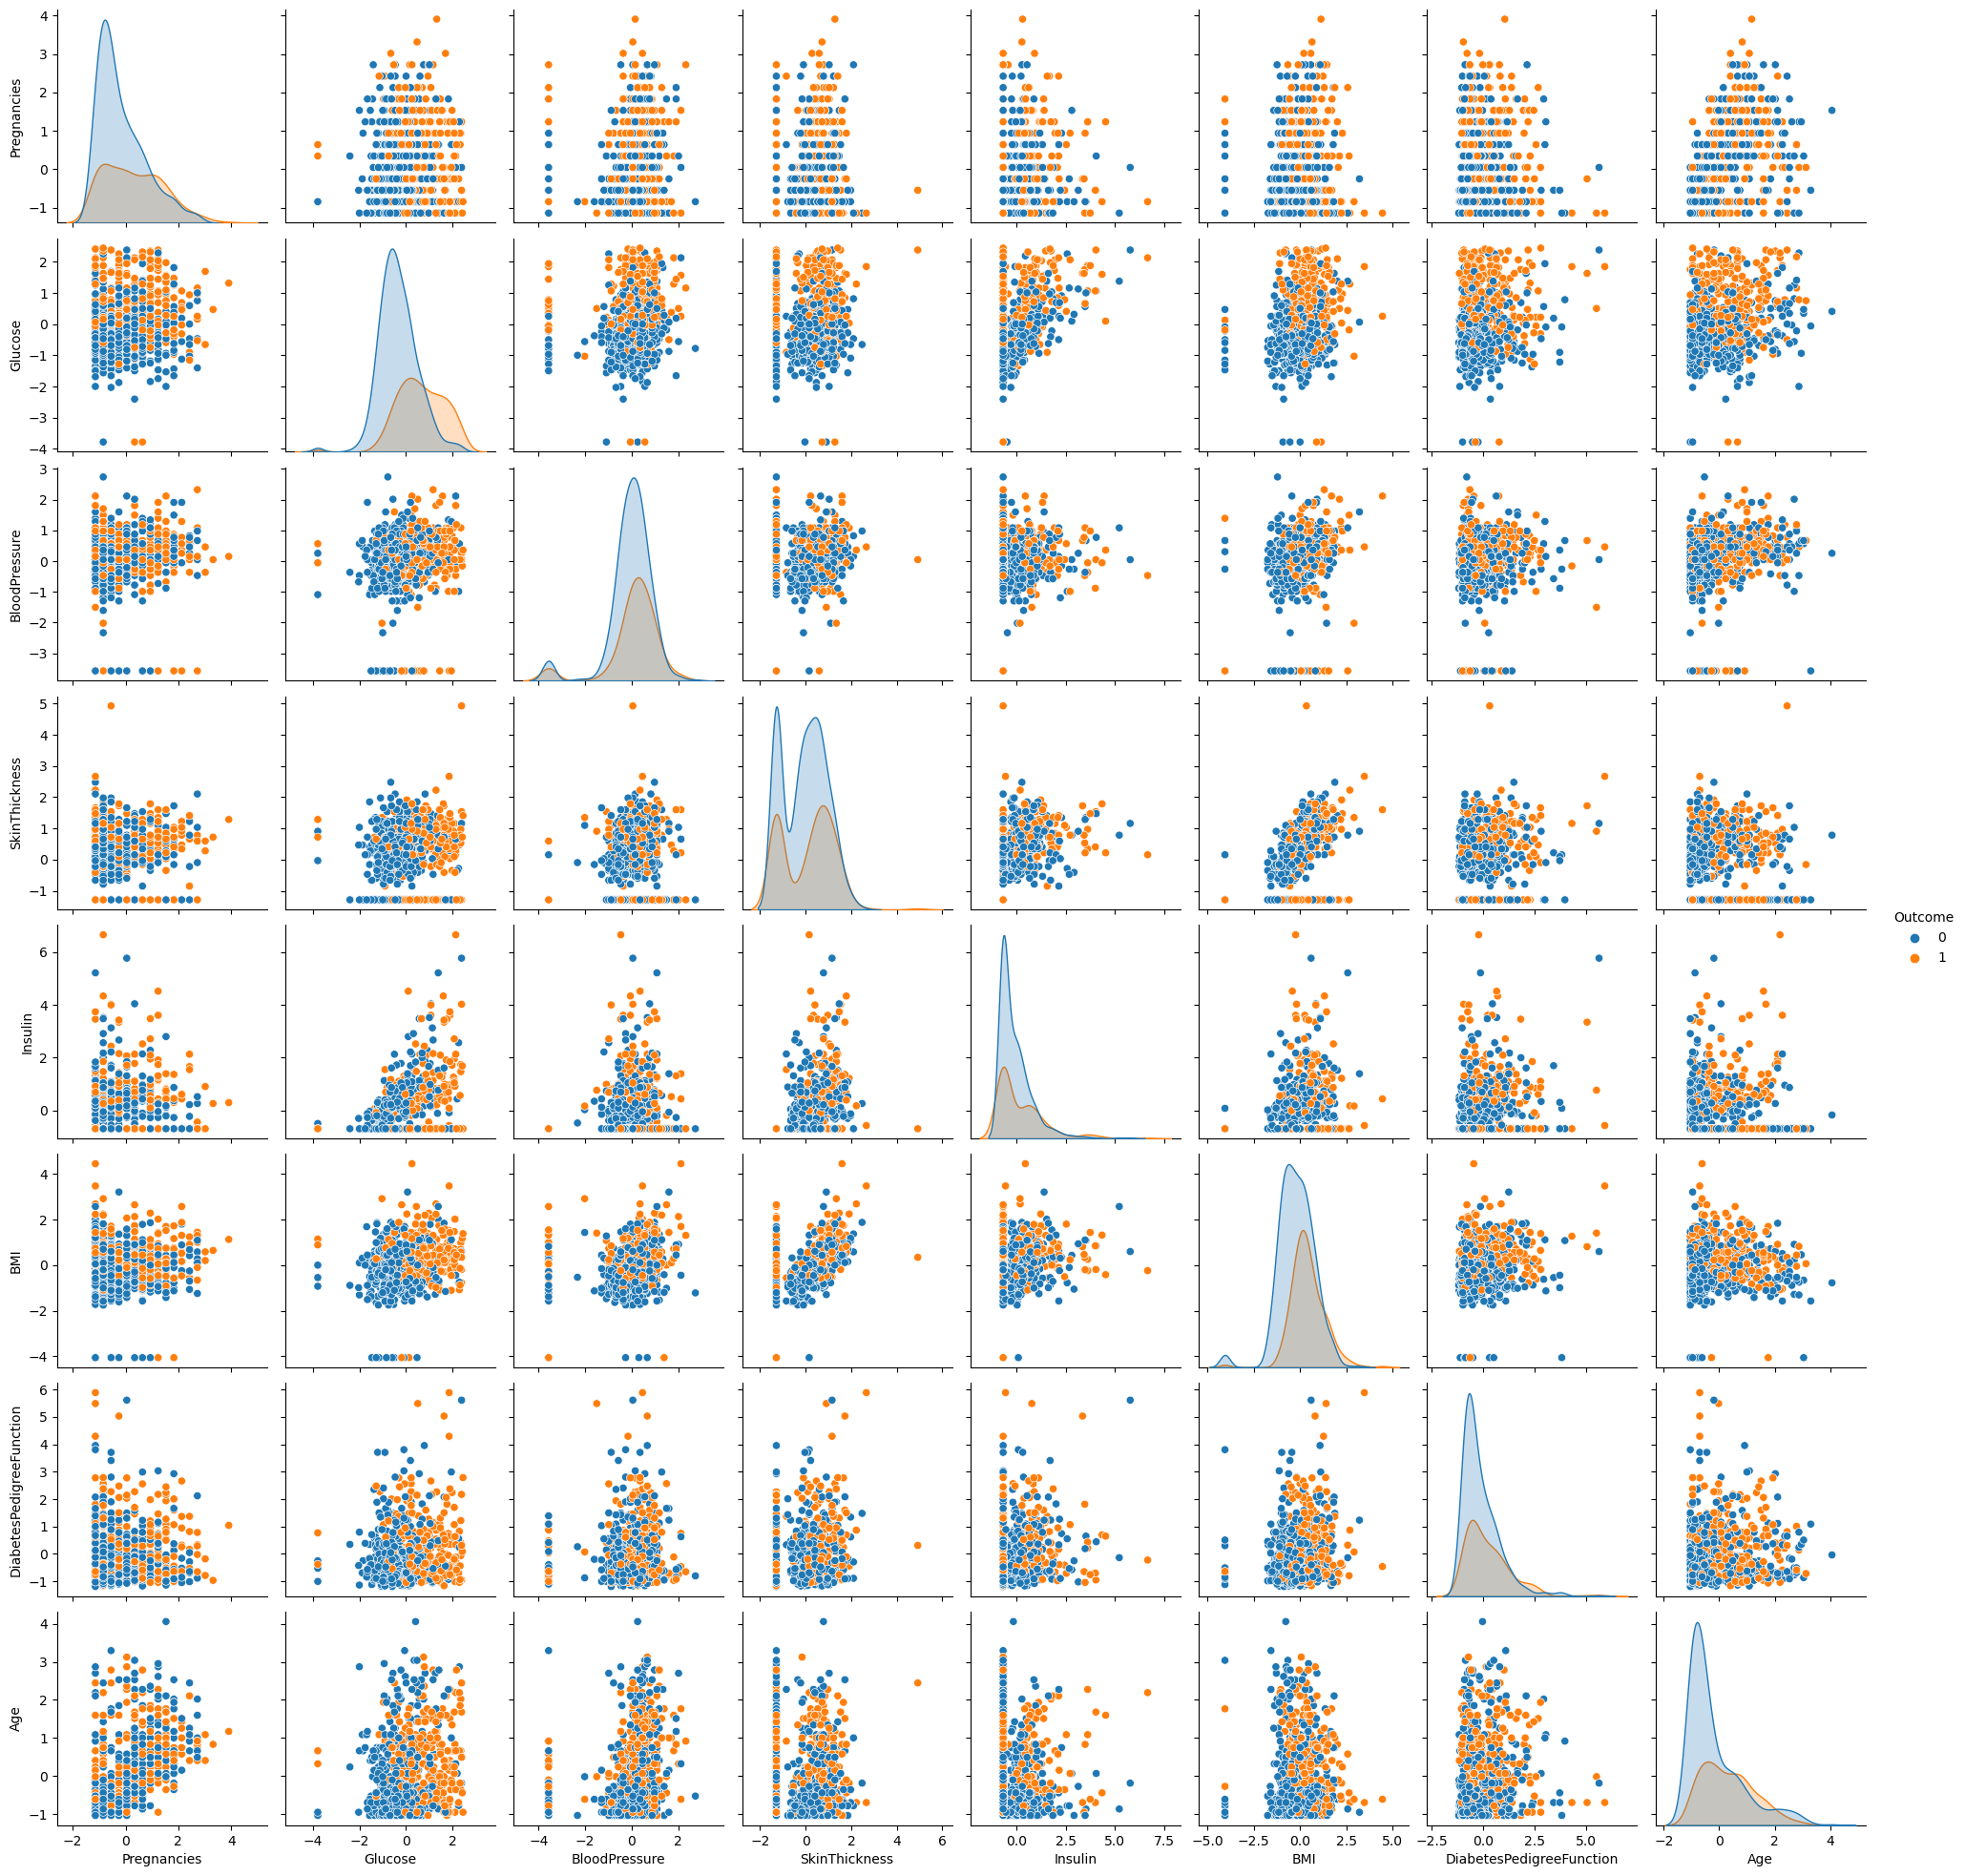

In [38]:
# Plot pairwise relationships with hue based on 'Outcome' column
sns.pairplot(data, hue='Outcome')
plt.show()

### Distribution

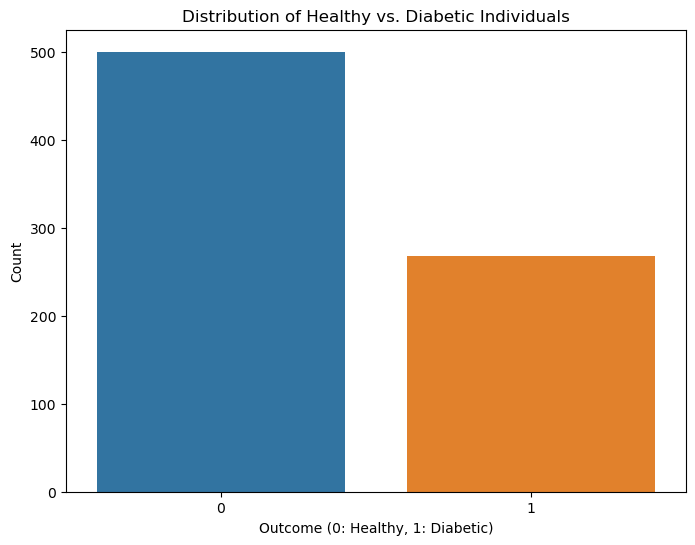

In [41]:
# healthy (Outcome=0) and diabetic (Outcome=1) individuals
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=data)
plt.title('Distribution of Healthy vs. Diabetic Individuals')
plt.xlabel('Outcome (0: Healthy, 1: Diabetic)')
plt.ylabel('Count')
plt.show()

In [43]:
# balance of available data
outcome_counts = data['Outcome'].value_counts()
balance_ratio = outcome_counts[0] / outcome_counts[1]

print("Number of Healthy Individuals (Outcome=0):", outcome_counts[0])
print("Number of Diabetic Individuals (Outcome=1):", outcome_counts[1])
print("Healthy to Diabetic Ratio: {:.2f}".format(balance_ratio))

Number of Healthy Individuals (Outcome=0): 500
Number of Diabetic Individuals (Outcome=1): 268
Healthy to Diabetic Ratio: 1.87


### Outliers

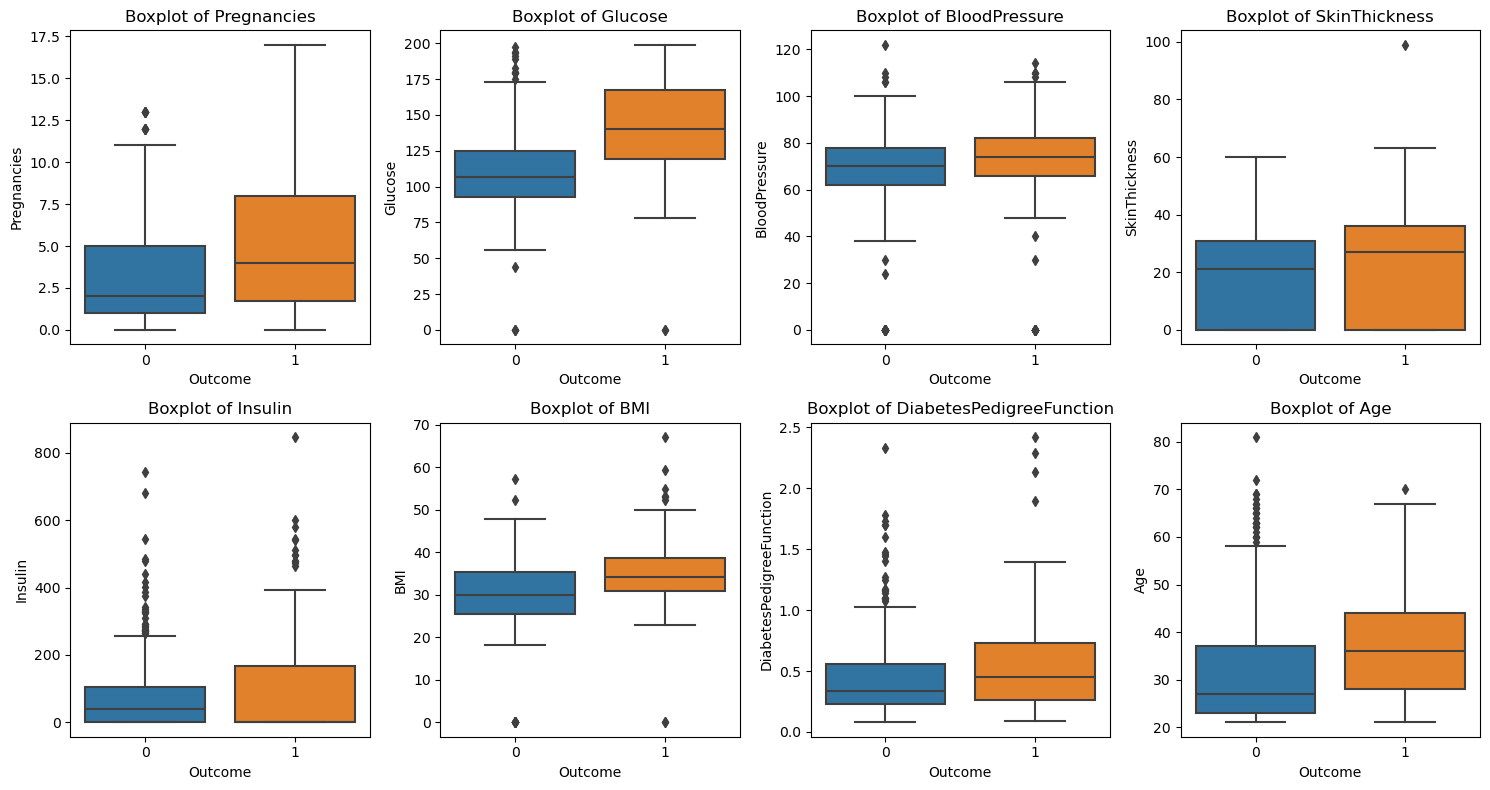

In [44]:
# boxplots for each column
plt.figure(figsize=(15, 8))
for i, column in enumerate(features, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='Outcome', y=column, data=diabetes_data)
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()


In [6]:
# Ca dictionary to store the count of outliers for each column
outlier_counts = {}

# Iterate through each column
for column in features:
    # Calculate the IQR
    Q1 = diabetes_data[column].quantile(0.25)
    Q3 = diabetes_data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # upper and lower bounds for outliers
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    # Count outliers
    upper_outliers = (diabetes_data[column] > upper_bound).sum()
    lower_outliers = (diabetes_data[column] < lower_bound).sum()
    
    # total number of outliers
    total_outliers = upper_outliers + lower_outliers
    outlier_counts[column] = total_outliers

for column, count in outlier_counts.items():
    print(f"Column '{column}' has {count} outliers.")


Column 'Pregnancies' has 4 outliers.
Column 'Glucose' has 5 outliers.
Column 'BloodPressure' has 45 outliers.
Column 'SkinThickness' has 1 outliers.
Column 'Insulin' has 34 outliers.
Column 'BMI' has 19 outliers.
Column 'DiabetesPedigreeFunction' has 29 outliers.
Column 'Age' has 9 outliers.


### Split data

In [7]:
# Normalize the data
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

In [8]:
# Split data into train+validation and test sets
train_val, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Outcome'])

# Split train+validation into train and validation sets
train, validation = train_test_split(train_val, test_size=0.125, random_state=42, stratify=train_val['Outcome'])  # 0.125 * 0.8 = 0.1

In [9]:
print(f"Train set shape: {train.shape}")
print(f"Validation set shape: {validation.shape}")
print(f"Test set shape: {test.shape}")

# Check distribution of the target variable in each dataset
print("\nDistribution of Outcome:")
print("Train:\n", train['Outcome'].value_counts(normalize=True))
print("Validation:\n", validation['Outcome'].value_counts(normalize=True))
print("Test:\n", test['Outcome'].value_counts(normalize=True))

Train set shape: (537, 9)
Validation set shape: (77, 9)
Test set shape: (154, 9)

Distribution of Outcome:
Train:
 Outcome
0    0.651769
1    0.348231
Name: proportion, dtype: float64
Validation:
 Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64
Test:
 Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64


### Model

In [10]:
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 100), nn.ReLU(), nn.BatchNorm1d(100),
            nn.Linear(100, 50), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 20), nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

model = DiabetesModel()

### Train

In [11]:
# Assuming 'train', 'validation', 'test' are already loaded and normalized Pandas DataFrames
X_train, y_train = torch.tensor(train[features].values).float(), torch.tensor(train['Outcome'].values).float()
X_val, y_val = torch.tensor(validation[features].values).float(), torch.tensor(validation['Outcome'].values).float()

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Epoch 1, Loss: 0.6863969494314754, Val Loss: 0.6655086477597555, Accuracy: 0.7402597402597403, Precision: 0.6842105263157895
Epoch 2, Loss: 0.5913248254972345, Val Loss: 0.55646679798762, Accuracy: 0.7922077922077922, Precision: 0.8235294117647058
Epoch 3, Loss: 0.498229526421603, Val Loss: 0.5007092157999674, Accuracy: 0.8051948051948052, Precision: 0.8
Epoch 4, Loss: 0.46743374537019167, Val Loss: 0.4826972186565399, Accuracy: 0.7922077922077922, Precision: 0.7391304347826086
Epoch 5, Loss: 0.46194945889360767, Val Loss: 0.48190341393152875, Accuracy: 0.7662337662337663, Precision: 0.6956521739130435
Epoch 6, Loss: 0.4427637878586264, Val Loss: 0.49471329649289447, Accuracy: 0.7792207792207793, Precision: 0.7272727272727273
Epoch 7, Loss: 0.4505364088451161, Val Loss: 0.4785768489042918, Accuracy: 0.7792207792207793, Precision: 0.7083333333333334
Epoch 8, Loss: 0.4297950110014747, Val Loss: 0.5029035806655884, Accuracy: 0.7792207792207793, Precision: 0.7083333333333334
Epoch 9, Loss:

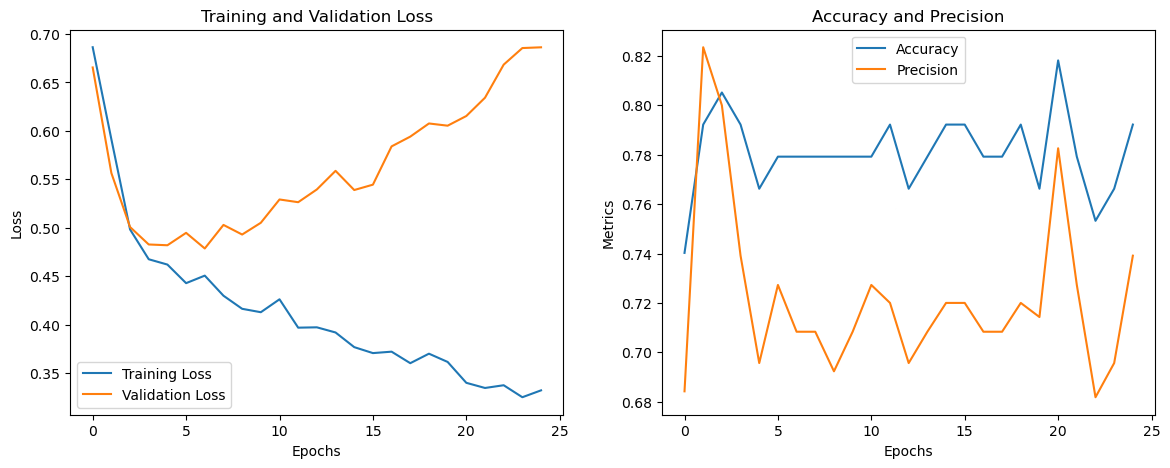

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    # Lists to keep track of metrics
    losses = []
    val_losses = []
    accuracies = []
    precisions = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        average_loss = running_loss / len(train_loader)
        losses.append(average_loss)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                val_running_loss += loss.item()
                predicted = (outputs > 0.5).float()
                all_preds.extend(predicted.numpy())
                all_labels.extend(labels.numpy())

        average_val_loss = val_running_loss / len(val_loader)
        val_losses.append(average_val_loss)
        
        accuracy = accuracy_score(all_labels, all_preds)
        accuracies.append(accuracy)
        
        precision = precision_score(all_labels, all_preds, zero_division=0)
        precisions.append(precision)
        
        print(f'Epoch {epoch+1}, Loss: {average_loss}, Val Loss: {average_val_loss}, Accuracy: {accuracy}, Precision: {precision}')

    # Plotting
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.plot(precisions, label='Precision')
    plt.title('Accuracy and Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    plt.show()

# Assuming the model and dataloaders are already defined
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

### Test

In [13]:
X_test, y_test = torch.tensor(test[features].values).float(), torch.tensor(test['Outcome'].values).float()
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [14]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float().squeeze()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    # Calculate metrics
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)

# Assuming the model is already trained and test_loader is defined
evaluate_model(model, test_loader)

Precision: 0.6
Recall: 0.6111111111111112
F1 Score: 0.6055045871559633
Confusion Matrix:
 [[78 22]
 [21 33]]


# 2. Interpret the model

## LIME

In [15]:
# Convert train DataFrame to numpy for LIME
train_data_np = train[features].to_numpy()
train_labels_np = train['Outcome'].to_numpy()

# Setting up LIME for tabular data
lime_explainer = LimeTabularExplainer(
    training_data=train_data_np,
    feature_names=features,
    class_names=['Non-diabetic', 'Diabetic'],
    mode='classification'
)

In [16]:
def pytorch_predict_proba(data):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        data_tensor = torch.tensor(data).float()
        outputs = model(data_tensor)
        outputs = outputs.numpy()  # Convert tensor outputs to numpy array
        return np.hstack((1-outputs, outputs))  # Stacking probabilities for both classes


# Select instances from test set (e.g., first three instances)
instances_to_explain = [0, 1, 2]

# Generate explanations
for idx in instances_to_explain:
    instance = X_test[idx].numpy()  # Convert tensor to numpy
    explanation = lime_explainer.explain_instance(
        data_row=instance,
        predict_fn=pytorch_predict_proba,
        num_features=5  # You can adjust the number of features you want to display
    )
    print(f'Explanation for instance {idx}:')
    explanation.show_in_notebook(show_table=True)

Explanation for instance 0:


Explanation for instance 1:


Explanation for instance 2:


## SHAP

In [17]:
def model_predict(data):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.tensor(data).float()
        output = model(data_tensor)
        return output.numpy()

In [18]:
# You already have:
instances_to_explain = [0, 1, 2]
background = X_train[:100].numpy()  # Using the first 100 instances for background

# Create the SHAP explainer
shap_explainer = shap.KernelExplainer(model_predict, background)

# Select actual data instances from X_test based on the indices
instances_to_explain_data = X_test[instances_to_explain].numpy()

# Compute SHAP values
shap_values = shap_explainer.shap_values(instances_to_explain_data)

  0%|          | 0/3 [00:00<?, ?it/s]

In [19]:
# Initialize JavaScript visualizations
shap.initjs()

In [20]:
for idx, shap_value in enumerate(shap_values):
    print(f"Processing instance {idx}")
    
    # Flatten the shap_value if it's 2D and we're only dealing with a single instance
    if shap_value.ndim == 2 and shap_value.shape[1] == 1:
        shap_value = shap_value.flatten()  # Convert from (8, 1) to (8,)
        print("Flattened shap_value to:", shap_value.shape)

    instance_features = instances_to_explain_data[idx]
    if instance_features.ndim == 1:
        instance_features = instance_features.reshape(1, -1)  # Ensure 2D array for features
        print("Reshaped instance_features to:", instance_features.shape)

    print("Shape of shap_value:", shap_value.shape)
    print("Shape of features:", instance_features.shape)

    shap_plot = shap.force_plot(
        shap_explainer.expected_value, 
        shap_value, 
        features=instance_features, 
        feature_names=features
    )
    
    shap.save_html(f"shap_force_plot_instance_{idx}.html", shap_plot)
    display(shap_plot)

Processing instance 0
Flattened shap_value to: (8,)
Reshaped instance_features to: (1, 8)
Shape of shap_value: (8,)
Shape of features: (1, 8)


Processing instance 1
Flattened shap_value to: (8,)
Reshaped instance_features to: (1, 8)
Shape of shap_value: (8,)
Shape of features: (1, 8)


Processing instance 2
Flattened shap_value to: (8,)
Reshaped instance_features to: (1, 8)
Shape of shap_value: (8,)
Shape of features: (1, 8)


## Compare between LIME & SHAP

In [21]:
def perturb_feature(instance, feature_index, new_value):
    perturbed_instance = instance.copy()
    perturbed_instance[feature_index] = new_value
    return perturbed_instance

def get_different_class_value(feature_index, instance_class):
    if instance_class == 0:
        different_class_data = train[(train['Outcome'] == 1)][features[feature_index]]
    else:
        different_class_data = train[(train['Outcome'] == 0)][features[feature_index]]
    
    return different_class_data.sample().values[0]

In [22]:
# Select an instance to analyze (e.g., the first instance)
instance = X_test[instances_to_explain[2]].numpy()
instance_class = y_test[instances_to_explain[2]].numpy()

print(f"Original instance: {instance}")
print(f"Original class: {instance_class}")

# Get the original model prediction
original_prediction = model_predict(instance.reshape(1, -1))[0]
print(f"Original prediction: {original_prediction}")

# Perform feature perturbation analysis
for feature_index in range(len(features)):
    new_value = get_different_class_value(feature_index, instance_class)
    perturbed_instance = perturb_feature(instance, feature_index, new_value)
    
    perturbed_prediction = model_predict(perturbed_instance.reshape(1, -1))[0]
    print(f"Perturbed prediction (feature {features[feature_index]}): {perturbed_prediction}")
    
    # Calculate the difference in prediction
    prediction_diff = abs(original_prediction - perturbed_prediction)
    print(f"Prediction difference (feature {features[feature_index]}): {prediction_diff}")
    print()

Original instance: [-0.5479186   0.03459802  0.35643175  0.40544543  1.0436887   0.49592704
  0.03359489 -0.6161107 ]
Original class: 0.0
Original prediction: [0.16754505]
Perturbed prediction (feature Pregnancies): [0.17787223]
Prediction difference (feature Pregnancies): [0.01032718]

Perturbed prediction (feature Glucose): [0.8477809]
Prediction difference (feature Glucose): [0.68023586]

Perturbed prediction (feature BloodPressure): [0.11241834]
Prediction difference (feature BloodPressure): [0.05512671]

Perturbed prediction (feature SkinThickness): [0.0130982]
Prediction difference (feature SkinThickness): [0.15444686]

Perturbed prediction (feature Insulin): [0.35430425]
Prediction difference (feature Insulin): [0.1867592]

Perturbed prediction (feature BMI): [0.3272746]
Prediction difference (feature BMI): [0.15972954]

Perturbed prediction (feature DiabetesPedigreeFunction): [0.09582191]
Prediction difference (feature DiabetesPedigreeFunction): [0.07172314]

Perturbed predicti

In [23]:
# Select an instance to analyze (e.g., the first instance)
instance = X_test[instances_to_explain[1]].numpy()
instance_class = y_test[instances_to_explain[1]].numpy()

print(f"Original instance: {instance}")
print(f"Original class: {instance_class}")

# Get the original model prediction
original_prediction = model_predict(instance.reshape(1, -1))[0]
print(f"Original prediction: {original_prediction}")

# Perform feature perturbation analysis
for feature_index in range(len(features)):
    new_value = get_different_class_value(feature_index, instance_class)
    perturbed_instance = perturb_feature(instance, feature_index, new_value)
    
    perturbed_prediction = model_predict(perturbed_instance.reshape(1, -1))[0]
    print(f"Perturbed prediction (feature {features[feature_index]}): {perturbed_prediction}")
    
    # Calculate the difference in prediction
    prediction_diff = abs(original_prediction - perturbed_prediction)
    print(f"Prediction difference (feature {features[feature_index]}): {prediction_diff}")
    print()

Original instance: [ 1.8278131  -1.6554478   1.9073642   0.15453319 -0.26742867  0.44515935
 -0.56438863  1.1707321 ]
Original class: 0.0
Original prediction: [0.04955493]
Perturbed prediction (feature Pregnancies): [0.6121342]
Prediction difference (feature Pregnancies): [0.5625793]

Perturbed prediction (feature Glucose): [0.34646782]
Prediction difference (feature Glucose): [0.29691288]

Perturbed prediction (feature BloodPressure): [0.04057123]
Prediction difference (feature BloodPressure): [0.0089837]

Perturbed prediction (feature SkinThickness): [0.00755819]
Prediction difference (feature SkinThickness): [0.04199674]

Perturbed prediction (feature Insulin): [0.09286795]
Prediction difference (feature Insulin): [0.04331302]

Perturbed prediction (feature BMI): [0.05036669]
Prediction difference (feature BMI): [0.00081176]

Perturbed prediction (feature DiabetesPedigreeFunction): [0.08714027]
Prediction difference (feature DiabetesPedigreeFunction): [0.03758534]

Perturbed predict

In [24]:
# Select an instance to analyze (e.g., the first instance)
instance = X_test[instances_to_explain[0]].numpy()
instance_class = y_test[instances_to_explain[0]].numpy()

print(f"Original instance: {instance}")
print(f"Original class: {instance_class}")

# Get the original model prediction
original_prediction = model_predict(instance.reshape(1, -1))[0]
print(f"Original prediction: {original_prediction}")

# Perform feature perturbation analysis
for feature_index in range(len(features)):
    new_value = get_different_class_value(feature_index, instance_class)
    perturbed_instance = perturb_feature(instance, feature_index, new_value)
    
    perturbed_prediction = model_predict(perturbed_instance.reshape(1, -1))[0]
    print(f"Perturbed prediction (feature {features[feature_index]}): {perturbed_prediction}")
    
    # Calculate the difference in prediction
    prediction_diff = abs(original_prediction - perturbed_prediction)
    print(f"Prediction difference (feature {features[feature_index]}): {prediction_diff}")
    print()

Original instance: [ 0.9369137   1.1925924  -0.26394126 -1.2882122  -0.6928906  -0.5828866
 -0.53720754  0.5751179 ]
Original class: 0.0
Original prediction: [0.85426605]
Perturbed prediction (feature Pregnancies): [0.75684285]
Prediction difference (feature Pregnancies): [0.0974232]

Perturbed prediction (feature Glucose): [0.88466203]
Prediction difference (feature Glucose): [0.03039598]

Perturbed prediction (feature BloodPressure): [0.85426605]
Prediction difference (feature BloodPressure): [0.]

Perturbed prediction (feature SkinThickness): [0.46980718]
Prediction difference (feature SkinThickness): [0.38445887]

Perturbed prediction (feature Insulin): [0.85426605]
Prediction difference (feature Insulin): [0.]

Perturbed prediction (feature BMI): [0.84459424]
Prediction difference (feature BMI): [0.00967181]

Perturbed prediction (feature DiabetesPedigreeFunction): [0.84271]
Prediction difference (feature DiabetesPedigreeFunction): [0.01155603]

Perturbed prediction (feature Age):

## LIME & SHAP for the whole test data

  0%|          | 0/154 [00:00<?, ?it/s]

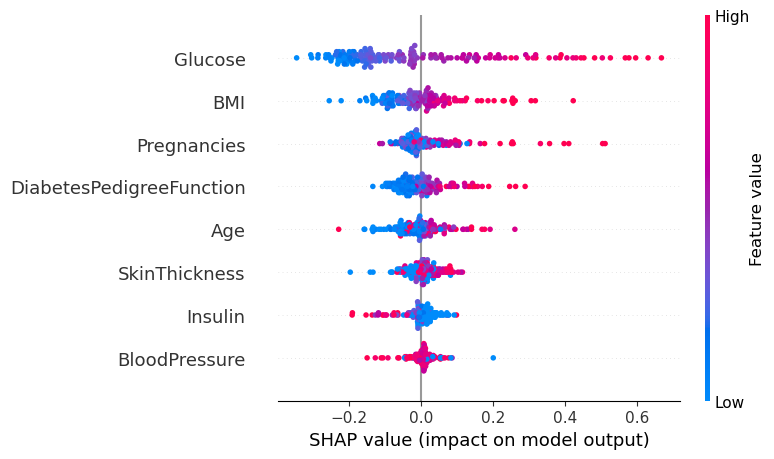

In [25]:
# Normalize the data
features = data.columns.drop('Outcome')
data[features] = scaler.fit_transform(data[features])

# LIME
train_data_np = train[features].to_numpy()
lime_explainer = LimeTabularExplainer(
    training_data=train_data_np,
    feature_names=features.tolist(),
    class_names=['Non-diabetic', 'Diabetic'],
    mode='classification'
)

def pytorch_predict_proba(data):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.tensor(data).float()
        outputs = model(data_tensor)
        return np.hstack((1 - outputs.detach().numpy(), outputs.detach().numpy()))

# Compute LIME explanations for all test instances
lime_weights = []
for idx in range(len(X_test)):
    explanation = lime_explainer.explain_instance(
        data_row=X_test[idx].numpy(),
        predict_fn=pytorch_predict_proba,
        num_features=len(features)
    )
    lime_weights.append(explanation.as_list())

# SHAP
def model_predict(data):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.tensor(data).float()
        output = model(data_tensor)
        return output.numpy()

background_data = X_train[:100].numpy()  # Using 100 instances as background
shap_explainer = shap.KernelExplainer(model_predict, background_data)
shap_values = shap_explainer.shap_values(X_test.numpy())

# Remove the unnecessary dimension
shap_values = shap_values.squeeze()

# Now, use the adjusted SHAP values in the summary_plot
shap.summary_plot(shap_values, X_test.numpy(), feature_names=features.tolist())

In [26]:
# Calculate the mean SHAP values for each feature
mean_shap_values = np.mean(shap_values, axis=0)

# Create a DataFrame to display the feature names and their corresponding mean SHAP values
shap_summary_df = pd.DataFrame({
    'Feature': features,  # Use 'features' directly as it is already a list
    'Mean SHAP Value': mean_shap_values
})

# Sort the DataFrame by the absolute mean SHAP values to see which features have the most impact
shap_summary_df['Absolute Mean SHAP Value'] = shap_summary_df['Mean SHAP Value'].abs()
shap_summary_df = shap_summary_df.sort_values(by='Absolute Mean SHAP Value', ascending=False).drop(columns='Absolute Mean SHAP Value')

# Print the DataFrame
print(shap_summary_df)

                    Feature  Mean SHAP Value
0               Pregnancies         0.024243
1                   Glucose        -0.005717
3             SkinThickness         0.005618
2             BloodPressure         0.005205
4                   Insulin        -0.002635
6  DiabetesPedigreeFunction         0.002419
7                       Age        -0.001659
5                       BMI        -0.001150


In [27]:
# Initialize weights dictionary
feature_weights = {f: 0.0 for f in features}

# Aggregation logic modified to handle conditional names
for idx in range(len(X_test)):
    explanation = lime_explainer.explain_instance(
        data_row=X_test[idx].numpy(),
        predict_fn=pytorch_predict_proba,
        num_features=len(features)
    )
    exp_map = dict(explanation.as_list())
    for exp_feature, weight in exp_map.items():
        # Map the LIME feature back to the original feature by parsing the string
        original_feature = exp_feature.split()[0]  # Assumes feature name is before the first space
        if original_feature in feature_weights:
            feature_weights[original_feature] += weight



In [28]:
# Normalize weights
num_instances = len(X_test)
for feature in feature_weights:
    if feature_weights[feature] != 0:
        feature_weights[feature] /= num_instances
    print(f"Average weight for {feature}: {feature_weights[feature]}")

Average weight for Pregnancies: 0.041772426850240935
Average weight for Glucose: 0.04584107240401972
Average weight for BloodPressure: -0.013213362922064197
Average weight for SkinThickness: -0.0032658574268718665
Average weight for Insulin: 0.0005451224399710647
Average weight for BMI: -0.008870764789247887
Average weight for DiabetesPedigreeFunction: 0.0010542228915168662
Average weight for Age: -0.007927482156294477


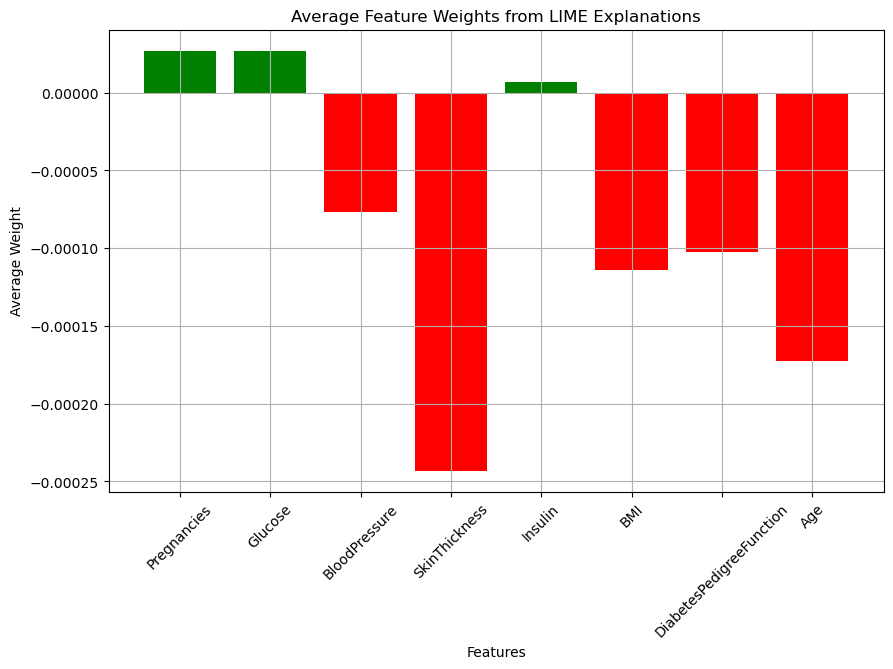

In [29]:
# Feature names and their corresponding average weights
features = [
    "Pregnancies", "Glucose", "BloodPressure",
    "SkinThickness", "Insulin", "BMI",
    "DiabetesPedigreeFunction", "Age"
]
average_weights = [
    2.7035917590317498e-05, 2.6664584066333998e-05, -7.704981851440991e-05,
    -0.0002430676745667022, 6.906232307214765e-06, -0.00011439371183593324,
    -0.00010273448355100399, -0.00017228905339537612
]

# Create a bar plot
plt.figure(figsize=(10, 6))
colors = ['green' if x >= 0 else 'red' for x in average_weights]
plt.bar(features, average_weights, color=colors)
plt.xlabel('Features')
plt.ylabel('Average Weight')
plt.title('Average Feature Weights from LIME Explanations')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

## NAM

In [30]:
import torch
import torch.nn as nn

class FeatureLayer(nn.Module):
    def __init__(self, input_dim):
        super(FeatureLayer, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

class InteractionLayer(nn.Module):
    def __init__(self, num_features):
        super(InteractionLayer, self).__init__()
        self.linear = nn.Linear(num_features, num_features)

    def forward(self, x):
        return self.linear(x)

class DiabetesNAM(nn.Module):
    def __init__(self):
        super(DiabetesNAM, self).__init__()
        self.feature_layers = nn.ModuleList([FeatureLayer(1) for _ in range(8)])
        self.interaction_layer = InteractionLayer(8)
        self.output_layer = nn.Linear(8, 1)

    def forward(self, x):
        feature_outputs = [layer(x[:, i].unsqueeze(1)) for i, layer in enumerate(self.feature_layers)]
        interaction_output = self.interaction_layer(torch.cat(feature_outputs, dim=1))
        output = self.output_layer(interaction_output)
        return torch.sigmoid(output)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from nam.models import NAM

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the NAM model
class DiabetesNAM(nn.Module):
    def __init__(self):
        super(DiabetesNAM, self).__init__()
        self.feature_layers = nn.ModuleList([FeatureLayer(1) for _ in range(8)])
        self.interaction_layer = InteractionLayer(8)
        self.output_layer = nn.Linear(8, 1)

    def forward(self, x, return_feature_outputs=False):
        feature_outputs = [layer(x[:, i].unsqueeze(1)) for i, layer in enumerate(self.feature_layers)]
        interaction_output = self.interaction_layer(torch.cat(feature_outputs, dim=1))
        output = self.output_layer(interaction_output)
        if return_feature_outputs:
            return torch.sigmoid(output), feature_outputs
        return torch.sigmoid(output)

# Initialize the NAM model
model = DiabetesNAM()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y.unsqueeze(1))  # Adjust here to add unsqueeze(1)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluate the model on the validation set
# Validation loop
model.eval()
val_loss = 0
correct = 0
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y.unsqueeze(1))  # Adjust here as well
        val_loss += loss.item()
        pred = torch.round(output)
        correct += (pred == y.unsqueeze(1)).sum().item()  # Adjust for accuracy calculation
accuracy = correct / len(val_loader.dataset)
print(f'Validation Loss: {val_loss / len(val_loader)}')
print(f'Validation Accuracy: {accuracy:.4f}')

# Use the trained model to make predictions on the test set
model.eval()
test_pred = []
with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        output = model(x)
        pred = torch.round(output)
        test_pred.extend(pred.cpu().numpy())

# Convert predictions to numpy array
test_pred = np.array(test_pred)

Epoch 1, Loss: 0.6969779133796692
Epoch 2, Loss: 0.7005197405815125
Epoch 3, Loss: 0.6549594402313232
Epoch 4, Loss: 0.6475446820259094
Epoch 5, Loss: 0.595373809337616
Epoch 6, Loss: 0.6147531270980835
Epoch 7, Loss: 0.6629068851470947
Epoch 8, Loss: 0.5397686958312988
Epoch 9, Loss: 0.491041362285614
Epoch 10, Loss: 0.6026674509048462
Epoch 11, Loss: 0.567287027835846
Epoch 12, Loss: 0.48465579748153687
Epoch 13, Loss: 0.4611116051673889
Epoch 14, Loss: 0.6052113175392151
Epoch 15, Loss: 0.6403285264968872
Epoch 16, Loss: 0.5199977159500122
Epoch 17, Loss: 0.6707280874252319
Epoch 18, Loss: 0.5705339908599854
Epoch 19, Loss: 0.482138991355896
Epoch 20, Loss: 0.3828454315662384
Epoch 21, Loss: 0.5545881390571594
Epoch 22, Loss: 0.4927429258823395
Epoch 23, Loss: 0.4549531042575836
Epoch 24, Loss: 0.5209656953811646
Epoch 25, Loss: 0.49122223258018494
Epoch 26, Loss: 0.3980342447757721
Epoch 27, Loss: 0.6625853776931763
Epoch 28, Loss: 0.33119627833366394
Epoch 29, Loss: 0.486582934856

AttributeError: 'list' object has no attribute 'to'